In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [3]:
import openpyxl

# Ruta del archivo Excel
archivo_excel = "C:/Users/pablo/Documents/IMPORTACION-VOLUMEN-2023-05.xlsx"

# Cargar el archivo Excel
wb = openpyxl.load_workbook(archivo_excel)

# Seleccionar una hoja específica (cambia "Sheet1" al nombre de la hoja que necesitas)
hoja = wb["IMPORTACION"]

# Inicializar una lista para almacenar los datos
datos = []

# Iterar a través de las filas de la hoja, omitiendo las primeras 6 filas
for fila in hoja.iter_rows(min_row=8, values_only=True):
    datos.append(fila)

# Cerrar el archivo Excel
wb.close()

# Crear un DataFrame de Pandas a partir de la lista de datos
columnas = hoja[7]  # Obtener las etiquetas de columna de la séptima fila
df = pd.DataFrame(datos, columns=[col.value for col in columnas])

# Ahora "df" es un DataFrame de Pandas que contiene los datos de Excel
df


,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,None,None,None,None,None,None,None,None,None,None
0,2001-01-01 00:00:00,0.00,27748.99,214581.84,0.00,0.00,0.00,0.00,194065.738095,820.00,...,None,None,None,None,None,None,None,None,None,None
1,2001-02-01 00:00:00,0.00,7503.57,294609.00,0.00,0.00,0.00,0.00,170703.380952,3054.00,...,None,None,None,None,None,None,None,None,None,None
2,2001-03-01 00:00:00,0.00,26304.32,315263.80,0.00,0.00,0.00,0.00,161837.371429,677.00,...,None,None,None,None,None,None,None,None,None,None
3,2001-04-01 00:00:00,0.00,7885.89,205653.00,0.00,0.00,0.00,0.00,163048.642857,3399.00,...,None,None,None,None,None,None,None,None,None,None
4,2001-05-01 00:00:00,0.00,8443.16,278371.30,0.00,0.00,0.00,0.00,171518.861905,585.00,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2023-03-01 00:00:00,30789.61,128594.46,149590.82,NaN,66515.19,1317519.91,4985.21,711978.350000,0.00,...,None,None,None,None,None,None,None,None,None,None
267,2023-04-01 00:00:00,25001.96,119761.46,134010.55,86.43,123298.87,1417182.73,21503.98,647666.300000,1840.46,...,None,None,None,None,None,None,None,None,None,None
268,2023-05-01 00:00:00,30440.94,171826.96,234819.33,6.00,94150.63,1428099.62,15047.82,713348.990000,0.00,...,None,None,None,None,None,None,None,None,None,None
269,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [5]:
superi = df.iloc[0:269,[0,11]]
superi["Fecha"] = pd.to_datetime(superi["Fecha"], format = "%Y-%m-%d")

In [6]:
traini = superi[0:int(len(superi)*0.7)]
testi = superi[int(len(superi)*0.7):len(superi)]

In [7]:
superi.set_index("Fecha", inplace=True)
traini.set_index("Fecha", inplace=True)
testi.set_index("Fecha", inplace=True)

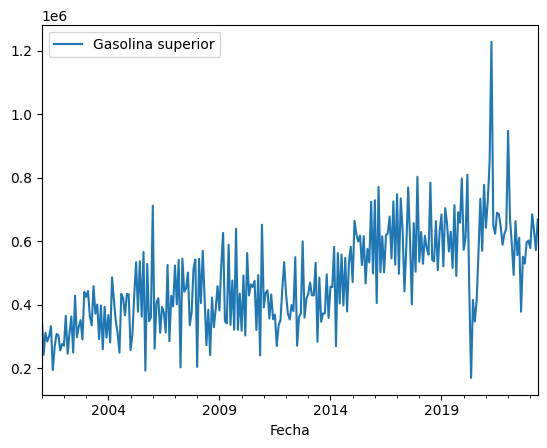

In [8]:
superi.plot()
plt.show()

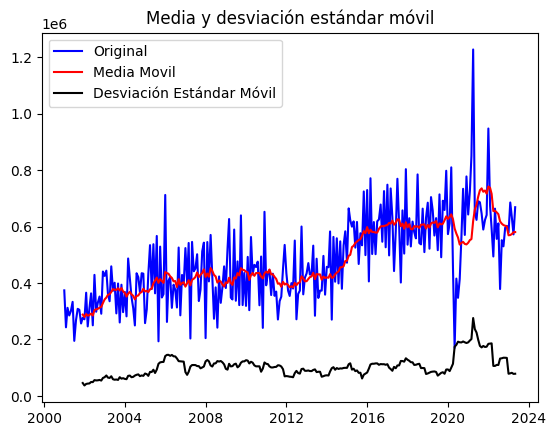

In [9]:
mediaMovil = superi.rolling(window=12).mean()
deMovil = superi.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(superi, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

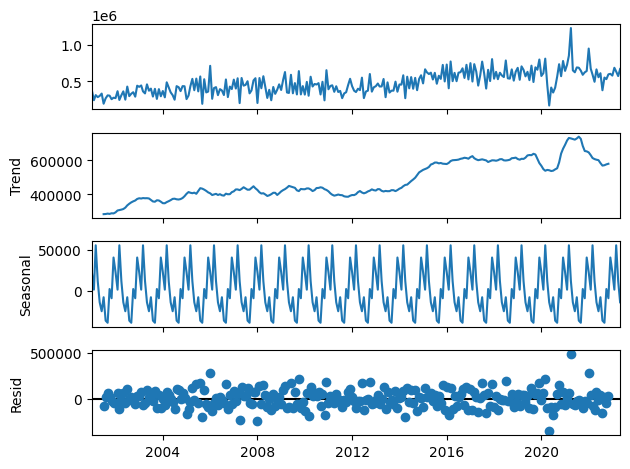

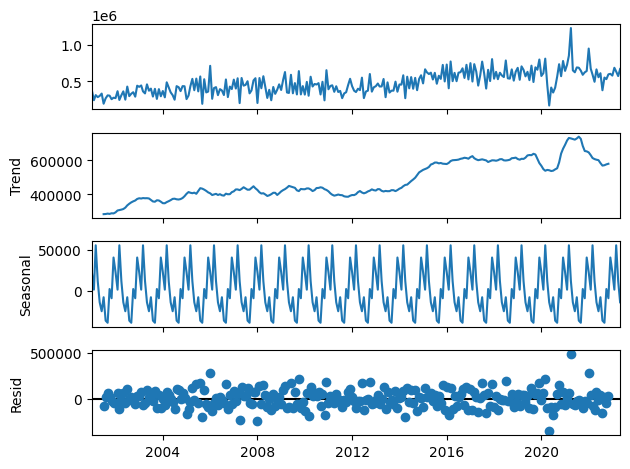

In [10]:
descomposicion = seasonal_decompose(superi)
descomposicion.plot()

In [11]:
dfTest = adfuller(superi, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -3.028435
p-value                        0.032323
# de retardos usados           3.000000
# de observaciones usadas    265.000000
Critical Value (1%)           -3.455270
Critical Value (5%)           -2.872509
Critical Value (10%)          -2.572615
dtype: float64


In [12]:
diffi = superi.diff()
diffi.fillna(0,inplace=True)
dfTest = adfuller(diffi)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Estadístico de prueba       -7.605893e+00
p-value                      2.322900e-11
# de retardos usados         1.100000e+01
# de observaciones usadas    2.570000e+02
Critical Value (1%)         -3.456054e+00
Critical Value (5%)         -2.872853e+00
Critical Value (10%)        -2.572799e+00
dtype: float64


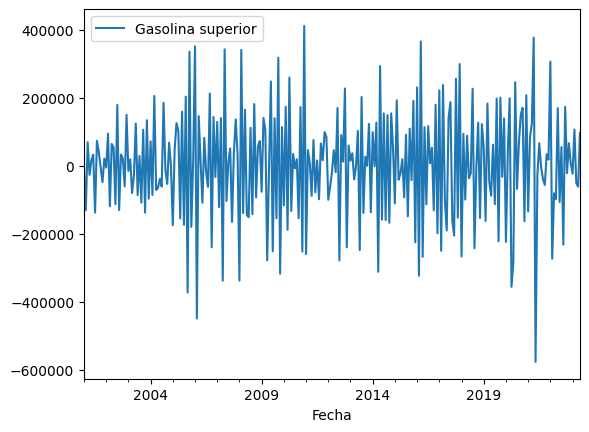

In [13]:
diffi.plot()
plt.show()

In [14]:
scaler = StandardScaler()
scaledi = scaler.fit_transform(diffi) 
scaledi[1:7]

array([[-0.81797429],
       [ 0.42085432],
       [-0.17432281],
       [ 0.09151111],
       [ 0.19344038],
       [-0.86305098]])

In [15]:
entrenamiento = round(0.6*len(scaledi))
val_prueba = round(0.2*len(scaledi))
test = scaledi[(entrenamiento+val_prueba)-1:]
validation = scaledi[(entrenamiento):entrenamiento+val_prueba+1]
train = scaledi[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

55

In [16]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [17]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

54

In [18]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1)                    12        
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [20]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 6s 14ms/step - loss: 0.8516 - val_loss: 1.0491
Epoch 2/50
161/161 [==============================] - 1s 5ms/step - loss: 0.8292 - val_loss: 1.0162
Epoch 3/50
161/161 [==============================] - 1s 5ms/step - loss: 0.8043 - val_loss: 0.9802
Epoch 4/50
161/161 [==============================] - 1s 5ms/step - loss: 0.7773 - val_loss: 0.9420
Epoch 5/50
161/161 [==============================] - 1s 5ms/step - loss: 0.7489 - val_loss: 0.9027
Epoch 6/50
161/161 [==============================] - 1s 5ms/step - loss: 0.7198 - val_loss: 0.8632
Epoch 7/50
161/161 [==============================] - 1s 5ms/step - loss: 0.6911 - val_loss: 0.8248
Epoch 8/50
161/161 [==============================] - 1s 5ms/step - loss: 0.6634 - val_loss: 0.7882
Epoch 9/50
161/161 [==============================] - 1s 5ms/step - loss: 0.6375 - val_loss: 0.7542
Epoch 10/50
161/161 [==============================] - 1s 5ms/step - loss: 0.6139 - val_loss: 0.723

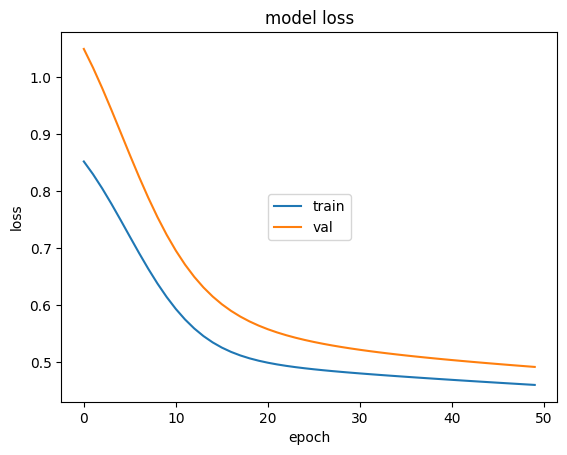

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [23]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif,dif_cant, Series, n):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = superi.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = superi.values , n=entrenamiento+val_prueba)

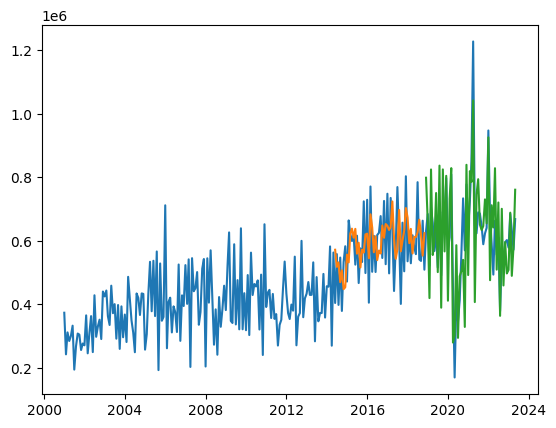

In [24]:
df_val = pd.DataFrame(prediccion_val,index=superi[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=superi[entrenamiento+len(df_val):len(superi)].index)


plt.plot(superi)
plt.plot(df_val)

plt.plot(df_test)

In [27]:
modelo2 = Sequential()
lote = 256
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo2.add(LSTM(lote, activation = "relu",batch_input_shape=(lote,paso,caracteristicas),dropout=0.25, recurrent_dropout = 0.))
modelo2.add(Dense(128, activation = "relu"))
modelo2.add(Dropout(0.3))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (256, 256)                264192    
                                                                 
 dense_2 (Dense)             (256, 128)                32896     
                                                                 
 dropout (Dropout)           (256, 128)                0         
                                                                 
 dense_3 (Dense)             (256, 1)                  129       
                                                                 
Total params: 297217 (1.13 MB)
Trainable params: 297217 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
modelo2.compile(loss="mse",optimizer="adam")

In [30]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
1/1 [==============================] - 0s 175ms/step - loss: 0.7884 - val_loss: 0.9427
Epoch 2/50
1/1 [==============================] - 0s 87ms/step - loss: 0.7698 - val_loss: 0.9248
Epoch 3/50
1/1 [==============================] - 0s 95ms/step - loss: 0.7606 - val_loss: 0.9065
Epoch 4/50
1/1 [==============================] - 0s 93ms/step - loss: 0.7421 - val_loss: 0.8876
Epoch 5/50
1/1 [==============================] - 0s 94ms/step - loss: 0.7301 - val_loss: 0.8684
Epoch 6/50
1/1 [==============================] - 0s 93ms/step - loss: 0.7173 - val_loss: 0.8489
Epoch 7/50
1/1 [==============================] - 0s 94ms/step - loss: 0.7435 - val_loss: 0.8293
Epoch 8/50
1/1 [==============================] - 0s 97ms/step - loss: 0.6780 - val_loss: 0.8091
Epoch 9/50
1/1 [==============================] - 0s 90ms/step - loss: 0.6958 - val_loss: 0.7887
Epoch 10/50
1/1 [==============================] - 0s 85ms/step - loss: 0.6808 - val_loss: 0.7680
Epoch 11/50
1/1 [===========

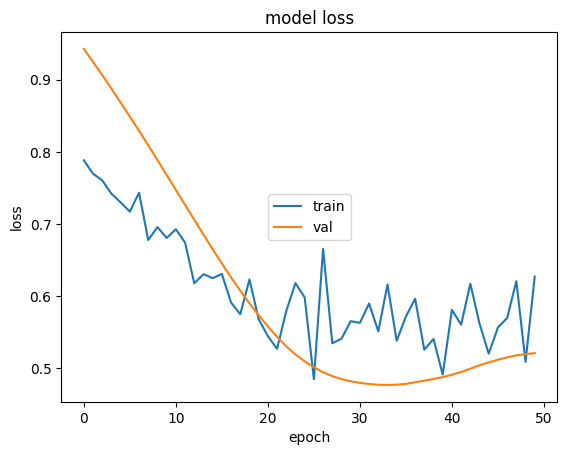

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [32]:
prediccion_val2 = []

def prediccion_fun(data,modelo, batch_size,scaler,dif,dif_cant, Series, n):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = superi.values , n=entrenamiento)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = superi.values , n=entrenamiento+val_prueba)

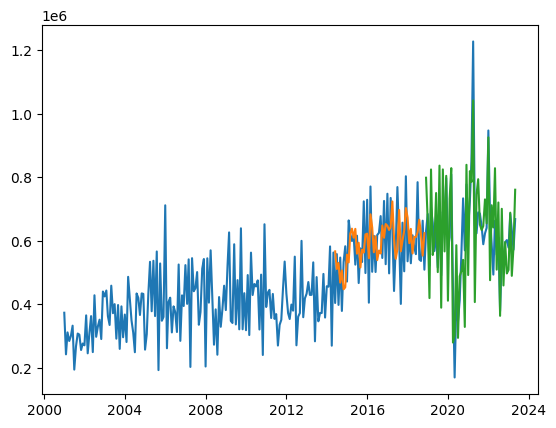

In [35]:
df_val2 = pd.DataFrame(prediccion_val2,index=superi[(entrenamiento):entrenamiento+val_prueba].index)
df_test2 = pd.DataFrame(prediccion_test2,index=superi[entrenamiento+len(df_val2):len(superi)].index)


plt.plot(superi)
plt.plot(df_val2)
plt.plot(df_test2)